In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import defaultdict, Counter
import json
from transformers import pipeline
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset
from transformers import DebertaV2ForSequenceClassification, DebertaV2TokenizerFast, Trainer, TrainingArguments,DebertaTokenizerFast
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from itertools import cycle
from transformers import TrainerCallback
from transformers import TrainerCallback, EvalPrediction

In [2]:
dataset = load_dataset("ag_news")

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [ ]:
# Initialize the tokenizer
tokenizer = DebertaTokenizerFast.from_pretrained('sileod/deberta-v3-small-tasksource-nli')

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=2)

# Apply tokenization to your dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Load the pre-trained Deberta model ignoring the size mismatches in the classifier layer
model = DebertaV2ForSequenceClassification.from_pretrained(
    'sileod/deberta-v3-small-tasksource-nli',
    num_labels=4,
    ignore_mismatched_sizes=True  # This will ignore the classifier weights and biases
)


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DebertaV2Tokenizer'. 
The class this function is called from is 'DebertaTokenizerFast'.


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
# Compute metrics function for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "confusion_matrix": confusion_matrix(labels, predictions).tolist()
    }


# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.01,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
)


In [13]:
# Train and evaluate the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Confusion Matrix
1,0.233800,0.192371,0.942500,"[[1806, 12, 45, 37], [12, 1873, 13, 2], [39, 9, 1720, 132], [38, 6, 92, 1764]]"


Trainer is attempting to log a value of "[[1806, 12, 45, 37], [12, 1873, 13, 2], [39, 9, 1720, 132], [38, 6, 92, 1764]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


TrainOutput(global_step=7500, training_loss=0.23376512044270834, metrics={'train_runtime': 8281.9815, 'train_samples_per_second': 14.489, 'train_steps_per_second': 0.906, 'total_flos': 1.589722103808e+16, 'train_loss': 0.23376512044270834, 'epoch': 1.0})

In [14]:
results = trainer.evaluate()

Trainer is attempting to log a value of "[[1806, 12, 45, 37], [12, 1873, 13, 2], [39, 9, 1720, 132], [38, 6, 92, 1764]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


In [15]:
results

{'eval_loss': 0.19237083196640015,
 'eval_accuracy': 0.9425,
 'eval_confusion_matrix': [[1806, 12, 45, 37],
  [12, 1873, 13, 2],
  [39, 9, 1720, 132],
  [38, 6, 92, 1764]],
 'eval_runtime': 184.7837,
 'eval_samples_per_second': 41.129,
 'eval_steps_per_second': 1.288,
 'epoch': 1.0}

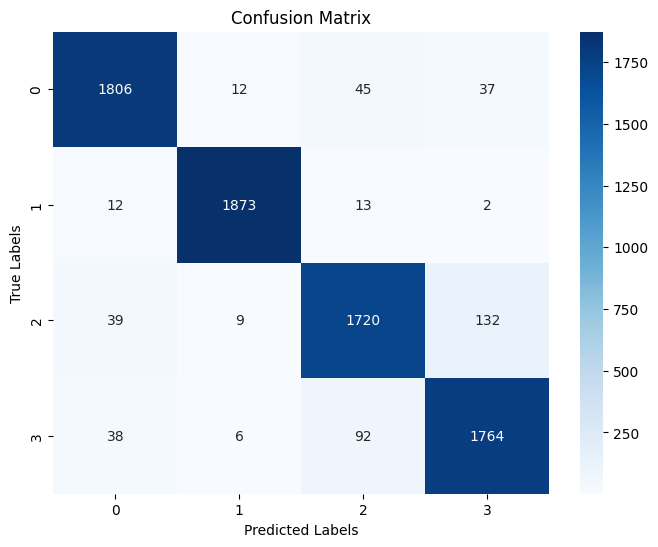

In [16]:

# 'results' contains the confusion matrix under 'confusion_matrix' key
confusion_matrix = np.array(results['eval_confusion_matrix'])
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
